# GMI simulation example

This notebook demonstrates the workflow for simulating simplified observations from the GPM Microwave Imager using the ``mwsim`` framework.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

> **Note:** We set the required ``MWSIM_DATA_PATH`` variable here. We also set ``OMP_NUM_THREADS`` to 1 to force ARTS to run sequentially as we will be distributing calculations across profiles.

In [2]:
%env OMP_NUM_THREADS=1
%env MWSIM_DATA_PATH=/home/simon/data/mwsim

env: OMP_NUM_THREADS=1
env: MWSIM_DATA_PATH=/home/simon/data/mwsim


## Model input data

This example assumes that the ECMWF data has been remapped to a regular longitude/latitude grid. The ``ORNLDataLoader`` class loads the data and creates KDTree structure to interpolate the model data to the pencil beams along which the radiative transfer simulations will be performed.

In [3]:
from mwsim.data_loaders import ORNLDataLoader

data_path = "/home/simon/data/mwsim/tropical_cyclone"
data_loader = ORNLDataLoader(data_path)

/home/simon/miniforge3/envs/mwsim/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/simon/miniforge3/envs/mwsim/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/simon/miniforge3/envs/mwsim/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.


## Overview

We plot the windspeed to get an idea of how the model scene looks like.

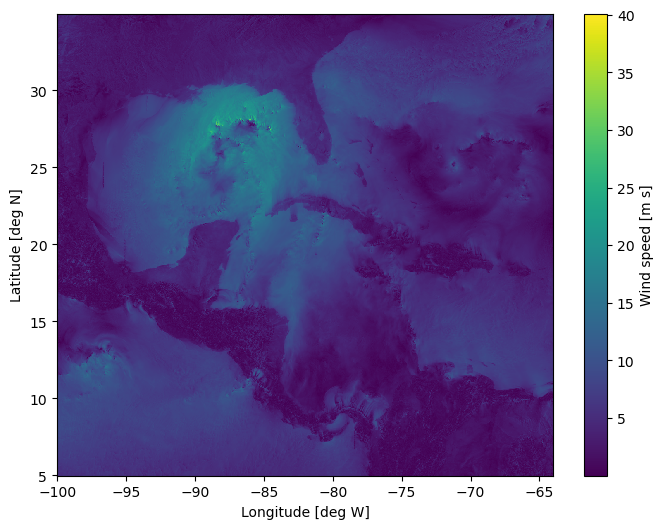

In [4]:
fig = plt.figure(figsize=(8, 6))
wind_speed = np.sqrt(data_loader.data["10u"].data ** 2 + data_loader.data["10v"].data ** 2)
lons = data_loader.data.longitude.data
lats = data_loader.data.latitude.data
m = plt.pcolormesh(lons, lats, wind_speed)
plt.xlabel("Longitude [deg W]")
plt.ylabel("Latitude [deg N]")

plt.colorbar(m, label="Wind speed [m s]")

## Sensor

Next, we use a sensor object to calculate the pencil beams of an overpass over the tropical cyclone.

In [5]:
from mwsim.sensors import GMI

The ``get_swath_profile_coordinates`` function calculates the slant coordinates along which the pencil beam corresponding to each pixel traverses the atmosphere. 

In [6]:
swath_start = [-88, 22]
swath_end = [-88, 32]
profiles = GMI.get_swath_profile_coordinates(swath_start, swath_end)

Below we visualize the surface coordinates of the beam to ensure that they cover the cyclone.

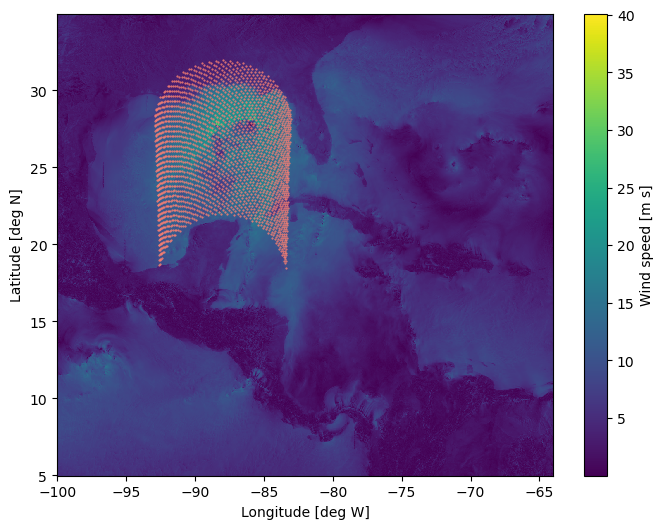

In [7]:
from mwsim.geometry import ecef_to_lla

fig = plt.figure(figsize=(8, 6))
wind_speed = np.sqrt(data_loader.data["10u"].data ** 2 + data_loader.data["10v"].data ** 2)
lons = data_loader.data.longitude.data
lats = data_loader.data.latitude.data
m = plt.pcolormesh(lons, lats, wind_speed)
plt.xlabel("Longitude [deg W]")
plt.ylabel("Latitude [deg N]")

swath_coords = ecef_to_lla(profiles[:, 0, :])
plt.colorbar(m, label="Wind speed [m s]")
plt.scatter(swath_coords[::8, 0], swath_coords[::8, 1], c="salmon", marker=".", s=1)

## Running simulations

The radiative transfer simulations are performed by a simulator. Here, we use the ARTS62Simulator, which is based on ARTS version 2.6.14. The simulator distributes simulations across multiple processes. The ``n_processes`` argument should be adapted to the machine that the simulations are run on.

In [8]:
from mwsim.simulators import ARTS26Simulator

simulator = ARTS26Simulator(GMI, n_processes=32)

To run the simulations, we iterate over the profiles for each beam, load the data from the data loader (this is done in the main process) and then push the profile data to the simulation, which performs the radiative transfer simulations for each profile asynchronously.

In [9]:
from tqdm import tqdm

for prof in tqdm(profiles, desc="Submitting jobs"):
    prof_data = data_loader.get_profile(prof)
    simulator.simulate(prof_data)

Submitting jobs: 100%|███████████████████████████████████████████████████████████████████████████████| 18343/18343 [03:18<00:00, 92.58it/s]


Finally, we collect the results from the simulator.

In [10]:
results = simulator.get_results(progress_bar=True)

Simulation progress:: 100%|█████████████████████████████████████████████████████████████████████████| 18343/18343 [01:44<00:00, 176.33it/s]


# Display results

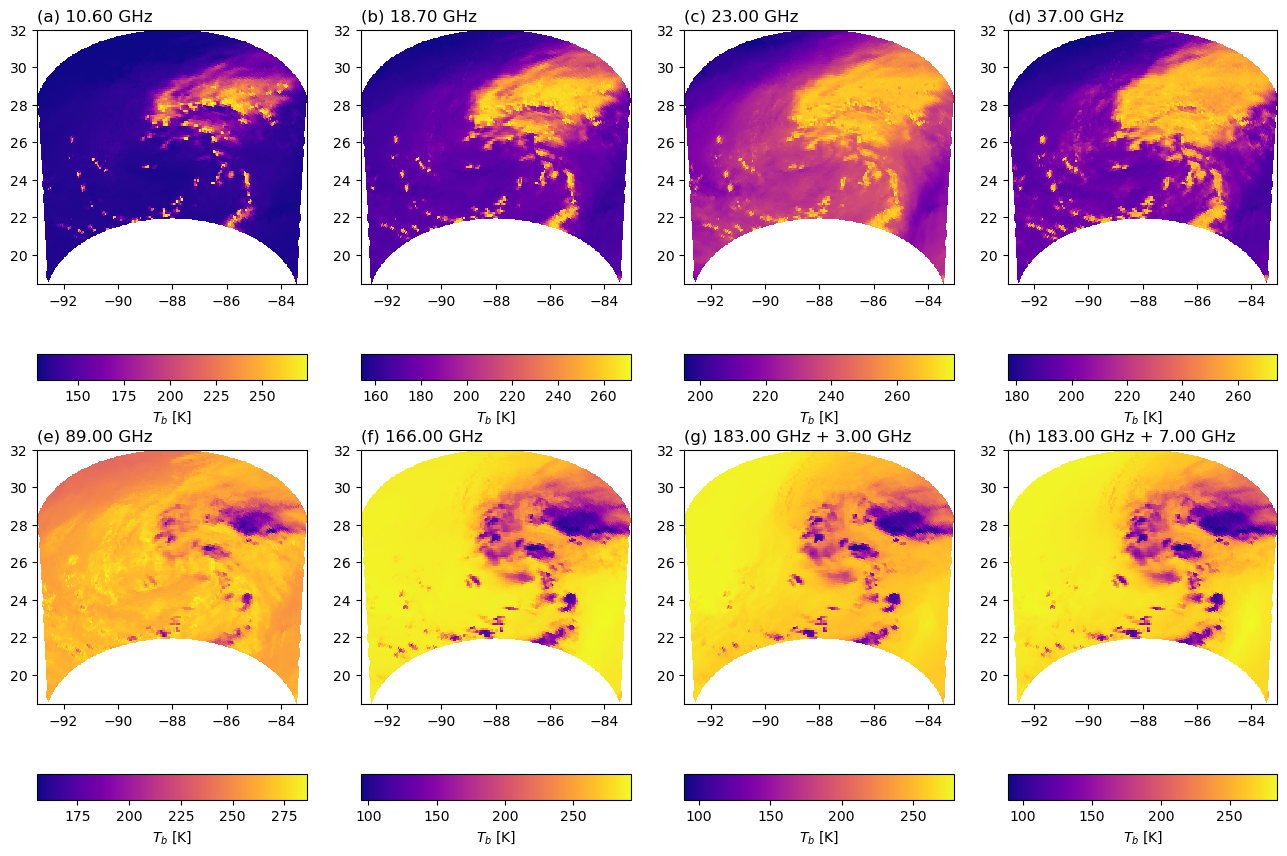

In [13]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 4, height_ratios=[1.0, 0.1, 1.0, 0.1], hspace=0.5)

tbs = results.brightness_temperatures.data.reshape((-1, 221, 8))
lons = results.longitude.data.reshape((-1, 221))
lats = results.latitude.data.reshape((-1, 221))
freqs = GMI.channel_frequencies
offs = GMI.channel_offsets

for chan in range(8):
    row_ind = chan // 4 * 2
    col_ind = chan % 4
    ax = fig.add_subplot(gs[row_ind, col_ind])
    m = ax.pcolormesh(lons, lats, tbs[..., chan], cmap="plasma")

    cax = fig.add_subplot(gs[row_ind + 1, col_ind])

    chan_name = f"{freqs[chan] / 1e9:.02f} GHz"
    if offs[chan] > 0.0:
        chan_name += f" + {offs[chan] / 1e9:.02f} GHz"
    ax.set_title(f"({chr(ord('a') + chan)}) {chan_name}", loc="left")

    plt.colorbar(m, cax=cax, label="$T_b$ [K]", orientation="horizontal")